In [1]:
import pandas as pd, numpy as np
import vivarium_output_loader as vol
import lsff_output_processing as lop

!whoami
!date

ndbs
Sat Mar 28 21:48:51 PDT 2020


In [2]:
%load_ext autoreload
%autoreload 2

# Check the effect size of folic acid fortification on NTDs, and the proportion of live births in each fortification group (i.e. compute population coverage of the intervention)

## 1. Load all count space data tables and see what they are

In [3]:
base_directory = '/share/costeffectiveness/results/vivarium_conic_lsff/v4.0_folic_acid_fortification'

locations_rundates = {
    'Ethiopia': '2020_03_18_23_04_26',
    'India': '2020_03_18_23_04_36',
    'Nigeria': '2020_03_18_23_04_42',
}

In [4]:
data = vol.load_all_transformed_count_data(base_directory, locations_rundates)

In [5]:
[k for k in data.keys() if k[0] == 'nigeria']

[('nigeria', 'gestational_age'),
 ('nigeria', 'transition_count'),
 ('nigeria', 'deaths'),
 ('nigeria', 'state_person_time'),
 ('nigeria', 'births_with_ntd'),
 ('nigeria', 'population'),
 ('nigeria', 'person_time'),
 ('nigeria', 'ylls'),
 ('nigeria', 'ylds'),
 ('nigeria', 'births'),
 ('nigeria', 'birth_weight')]

## 2. Load NTD births and live births tables

In [6]:
ntd_births = data[('nigeria', 'births_with_ntd')]
ntd_births.head()

,year,sex,fortification_group,measure,input_draw,scenario,value
0,2020,female,false,live_births_with_ntds,21,baseline,44.0
1,2020,female,false,live_births_with_ntds,21,folic_acid_fortification_scale_up,35.0
2,2020,female,false,live_births_with_ntds,29,baseline,55.0
3,2020,female,false,live_births_with_ntds,29,folic_acid_fortification_scale_up,44.0
4,2020,female,false,live_births_with_ntds,55,baseline,60.0


In [7]:
live_births = data[('nigeria', 'births')]
live_births.head()

,year,sex,fortification_group,measure,input_draw,scenario,value
0,2020,female,false,live_births,21,baseline,20286.0
1,2020,female,false,live_births,21,folic_acid_fortification_scale_up,16490.0
2,2020,female,false,live_births,29,baseline,20252.0
3,2020,female,false,live_births,29,folic_acid_fortification_scale_up,16478.0
4,2020,female,false,live_births,55,baseline,20386.0


## 3. Compute conditional risk of NTDs in fortified and unfortified groups

In [16]:
def conditional_ntd_risk(births_with_ntd, live_births, conditioned_on, multiplier=1):
    
    # Columns in both dataframes are:
    # ['year', 'sex', 'fortification_group', 'measure', 'input_draw', 'scenario', 'value']
    
    # The index columns will NOT be aggregated over
    index_columns = ['input_draw', 'scenario'] + conditioned_on
    
    # In both dataframes, group by the index columns, and aggregate
    #'value' column over remaining columns by summing
    births_with_ntd = births_with_ntd.groupby(index_columns).value.sum()
    live_births = live_births.groupby(index_columns).value.sum()
    
    # Divide the two pandas Series to get birth prevalence
    # in each subgroup we conditioned on.
    # Multiply by the multiplier to get desired units (e.g. per 1000 live births)
    ntd_risk = multiplier * births_with_ntd / live_births
    
    # Drop any rows where we divided by 0 because there were no births
    ntd_risk.dropna(inplace=True)
    
    return ntd_risk.reset_index()

def relative_risk_of_ntds(conditional_ntd_risk, numerator_query, denominator_query):
    numerator = conditional_ntd_risk.query(numerator_query)

In [24]:
conditioned_on = ['year', 'fortification_group']
multiplier = 1000

df = conditional_ntd_risk(ntd_births, live_births, conditioned_on, multiplier)
df.head()

,input_draw,scenario,year,fortification_group,value
0,21,baseline,2020,false,2.710093
1,21,baseline,2020,true,0.819001
2,21,baseline,2021,false,2.525741
3,21,baseline,2021,true,2.413839
4,21,baseline,2022,false,2.326418


In [25]:
df.shape

(500, 5)

In [27]:
df.query('scenario == "baseline"').groupby(
    conditioned_on).value.describe(percentiles=[0.025, 0.975])

count      mean       std       min      2.5%  \
year fortification_group                                                  
2020 false                 25.0  2.679439  0.418728  1.932944  2.053354   
     true                  25.0  1.625869  0.825508  0.267237  0.535058   
2021 false                 25.0  2.639663  0.274397  1.934517  2.095934   
     true                  25.0  1.640869  0.428007  0.691946  0.959717   
2022 false                 25.0  2.634820  0.268929  2.226763  2.281330   
     true                  25.0  1.740682  0.472118  0.997009  1.010502   
2023 false                 25.0  2.677424  0.237874  2.341781  2.369799   
     true                  25.0  1.659422  0.577847  0.718047  0.861068   
2024 false                 25.0  2.624014  0.271749  2.215463  2.268329   
     true                  25.0  1.438869  0.360530  0.809935  0.831445   

                               50%     97.5%       max  
year fortification_group                                
2020 false                2.617172  3.622014  3.674160  
     true                 1.436782  3.239306  3.557814  
2021 false                2.618341  3.093227  3.283296  
     true                 1.691638  2.482341  2.585093  
2022 false                2.622809  3.208310  3.231619  
     true                 1.719057  2.473734  2.490823  
2023 false                2.634175  3.183101  3.270705  
     true                 1.567965  2.583706  2.584350  
2024 false                2.552286  3.227151  3.424863  
     true                 1.426737  2.077186  2.138752

In [34]:
df.head()

,input_draw,scenario,year,fortification_group,value
0,21,baseline,2020,false,2.710093
1,21,baseline,2020,true,0.819001
2,21,baseline,2021,false,2.525741
3,21,baseline,2021,true,2.413839
4,21,baseline,2022,false,2.326418


In [37]:
df.scenario.unique()

array(['baseline', 'folic_acid_fortification_scale_up'], dtype=object)

In [40]:
index_cols = ['year', 'input_draw', 'scenario']
# scenario = 'folic_acid_fortification_scale_up'

numerator = df.query('fortification_group == "true"')
denominator = df.query('fortification_group == "false"')

numerator = numerator.set_index(index_cols).value
denominator = denominator.set_index(index_cols).value

rr = numerator / denominator
rr = rr.reset_index()
rr.head()

,year,input_draw,scenario,value
0,2020,21,baseline,0.302204
1,2021,21,baseline,0.955696
2,2022,21,baseline,0.971983
3,2023,21,baseline,0.805795
4,2024,21,baseline,0.488840


In [41]:
rr.groupby(['year', 'scenario']).value.describe(percentiles=[0.025, 0.975])

count      mean       std       min  \
year scenario                                                                 
2020 baseline                            25.0  0.616429  0.325427  0.103287   
     folic_acid_fortification_scale_up   25.0  0.599473  0.173103  0.186618   
2021 baseline                            25.0  0.631571  0.192432  0.262525   
     folic_acid_fortification_scale_up   25.0  0.580178  0.115360  0.358731   
2022 baseline                            25.0  0.667381  0.194323  0.335394   
     folic_acid_fortification_scale_up   25.0  0.644636  0.145287  0.432210   
2023 baseline                            25.0  0.617587  0.198767  0.269264   
     folic_acid_fortification_scale_up   25.0  0.625831  0.118822  0.355788   
2024 baseline                            25.0  0.552025  0.144390  0.321591   
     folic_acid_fortification_scale_up   25.0  0.560099  0.108645  0.356108   

                                            2.5%       50%     97.5%       max  
year scenario                                                                   
2020 baseline                           0.202571  0.526720  1.257008  1.517023  
     folic_acid_fortification_scale_up  0.270356  0.610070  0.903924  0.946358  
2021 baseline                           0.313014  0.591792  1.041357  1.052410  
     folic_acid_fortification_scale_up  0.389122  0.580983  0.804958  0.818935  
2022 baseline                           0.361029  0.628839  0.990120  1.017325  
     folic_acid_fortification_scale_up  0.434029  0.654591  0.899989  0.908438  
2023 baseline                           0.316015  0.578033  0.946648  0.988655  
     folic_acid_fortification_scale_up  0.433083  0.621070  0.866904  0.928779  
2024 baseline                           0.328530  0.563904  0.814182  0.832862  
     folic_acid_fortification_scale_up  0.359676  0.556570  0.750745  0.874089

In [33]:
rr.shape

(125, 2)

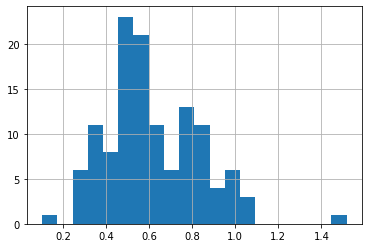

In [56]:
scenario = 'baseline'
# scenario = 'folic_acid_fortification_scale_up'
rr.query('scenario == @scenario').value.hist(bins=20)

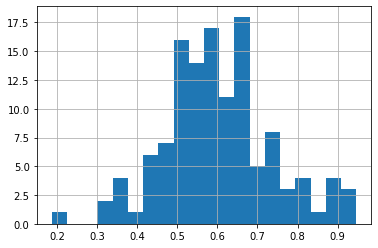

In [57]:
scenario = 'folic_acid_fortification_scale_up'
rr.query('scenario == @scenario').value.hist(bins=20)

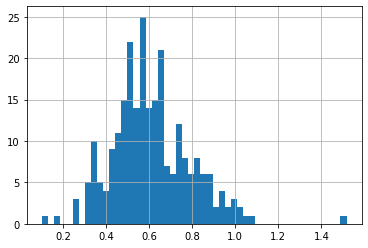

In [55]:
rr.value.hist(bins=50)